# NYPD Crime Reports Dataset

You are asked to analyze the dataset with all the valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of 2022.

The dataset is available at:
https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

It is a big dataset with ~8 million crimes reported to NYPD.

## Attribute Description

Below you can find the description of the attributes, and their datatypes.

| Column | Description | Data Type
|--------|-------------------|----|
| CMPLNT_NUM | Randomly generated persistent ID for each complaint  | bigint(20) |
| CMPLNT_FR | Exact datetime of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists) | datetime |
| CMPLNT_TO | Ending datetime of occurrence for the reported event, if exact time of occurrence is unknown | datetime
| RPT_DT | Date event was reported to police  | date
| KY_CD | Three digit offense classification code | char(3)
| PD_CD | Three digit internal classification code (more granular than Key Code) | char(3)
| JURISDICTION_CODE	| | smallint(6)
| CRM_ATPT_CPTD_CD | Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely | enum('COMPLETED','ATTEMPTED')
| LAW_CAT_CD | Level of offense: felony, misdemeanor, violation  | enum('FELONY','MISDEMEANOR','VIOLATION')
| BORO_NM | The name of the borough in which the incident occurred | enum('BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND')
| ADDR_PCT_CD | The precinct in which the incident occurred | char(3)
| LOC_OF_OCCUR_DESC | Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of | enum('FRONT OF','INSIDE','OPPOSITE OF','OUTSIDE','REAR OF')
| PATROL_BORO | |	enum('PATROL BORO BRONX','PATROL BORO BKLYN SOUTH','PATROL BORO BKLYN NORTH','PATROL BORO MAN SOUTH','PATROL BORO MAN NORTH','PATROL BORO QUEENS NORTH','PATROL BORO QUEENS SOUTH','PATROL BORO STATEN ISLAND')
| PREM_TYP_DESC | Specific description of premises; grocery store, residence, street, etc. | varchar(80)
| SUSP_RACE  | |		enum('UNKNOWN','BLACK','WHITE','WHITE HISPANIC','ASIAN / PACIFIC ISLANDER','BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE')
| VIC_RACE  | |		enum('UNKNOWN','BLACK','WHITE','WHITE HISPANIC','ASIAN / PACIFIC ISLANDER','BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE')
| SUSP_AGE_GROUP  | |		enum('<18','18-24','25-44','45-64','65+')
| VIC_AGE_GROUP  | |		enum('<18','18-24','25-44','45-64','65+')
| SUSP_SEX  | |		enum('M','F')
| VIC_SEX  | |	enum('M','F','E','D')
| Latitude | Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)  | double
| Longitude | Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326) | double


### Auxiliary Tables

We also have three auxiliary tables `jurisdiction_codes`, `offense_codes`, `penal_codes`, which provide descriptions for the `JURISDICTION_CODE`, `KY_CD`, and `PD_CD` attributes of the main table.




Additional Notes: https://www1.nyc.gov/assets/nypd/downloads/pdf/analysis_and_planning/incident_level_data_footnotes.pdf



## MySQL Database

For your convenience, the dataset is stored in the `nypd` database on the MySQL Server `db.ipeirotis.org`. You can connect and see the dataset using your standard username and password (`student`, `dwdstudent2015`).

In [1]:
!sudo pip3 install  -U -q geopandas PyMySQL sqlalchemy sql_magic matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 9.5 MB/s eta 0:00:00


In [2]:
!sudo pip3 install -U matplotlib

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
conn_string = 'mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset={encoding}'.format(
    user='student',
    password='dwdstudent2015',
    host = 'db.ipeirotis.org',
    port=3306,
    db='nypd',
    encoding = 'utf8'
)
engine = create_engine(conn_string)

# Questions

You are asked to analyze the dataset and provide answers for the questions below. You can answer the questions using Python, SQL, or a combination of them.

## Question 1: Composition of crimes

* **Question 1a**: How many total reported crimes are in the dataset?
* **Question 1b**: Analyze the column `LAW_CAT_CD` and provide the breakdown of the reported crimes among `FELONY`,`MISDEMEANOR`, and `VIOLATION`, i.e., report the number of felonies, misdemeanors, and violations. Create a bar plot showing the values across the three crime types.
* **Question 1c**: Across **felonies**, report the number of crimes, broken down by  offense description (as reported in the `OFNS_DESC` column of the `offense_codes` table). Create a bar plot showing the frequency of the top-10 offense descriptions for the felonies.

In [5]:
# Question 1a: How many total reported crimes are in the dataset?

sql = '''
	SELECT COUNT(DISTINCT CMPLNT_NUM) AS total_reported_crimes
FROM nypd
'''
with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,total_reported_crimes
0,8338675


In [6]:
# Question 1b: Analyze the column LAW_CAT_CD and report the number of felonies, misdemeanors, and violations.

sql = '''
SELECT LAW_CAT_CD, COUNT(*) AS count
FROM nypd
GROUP BY LAW_CAT_CD
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,LAW_CAT_CD,count
0,FELONY,2596201
1,MISDEMEANOR,4625621
2,VIOLATION,1116853


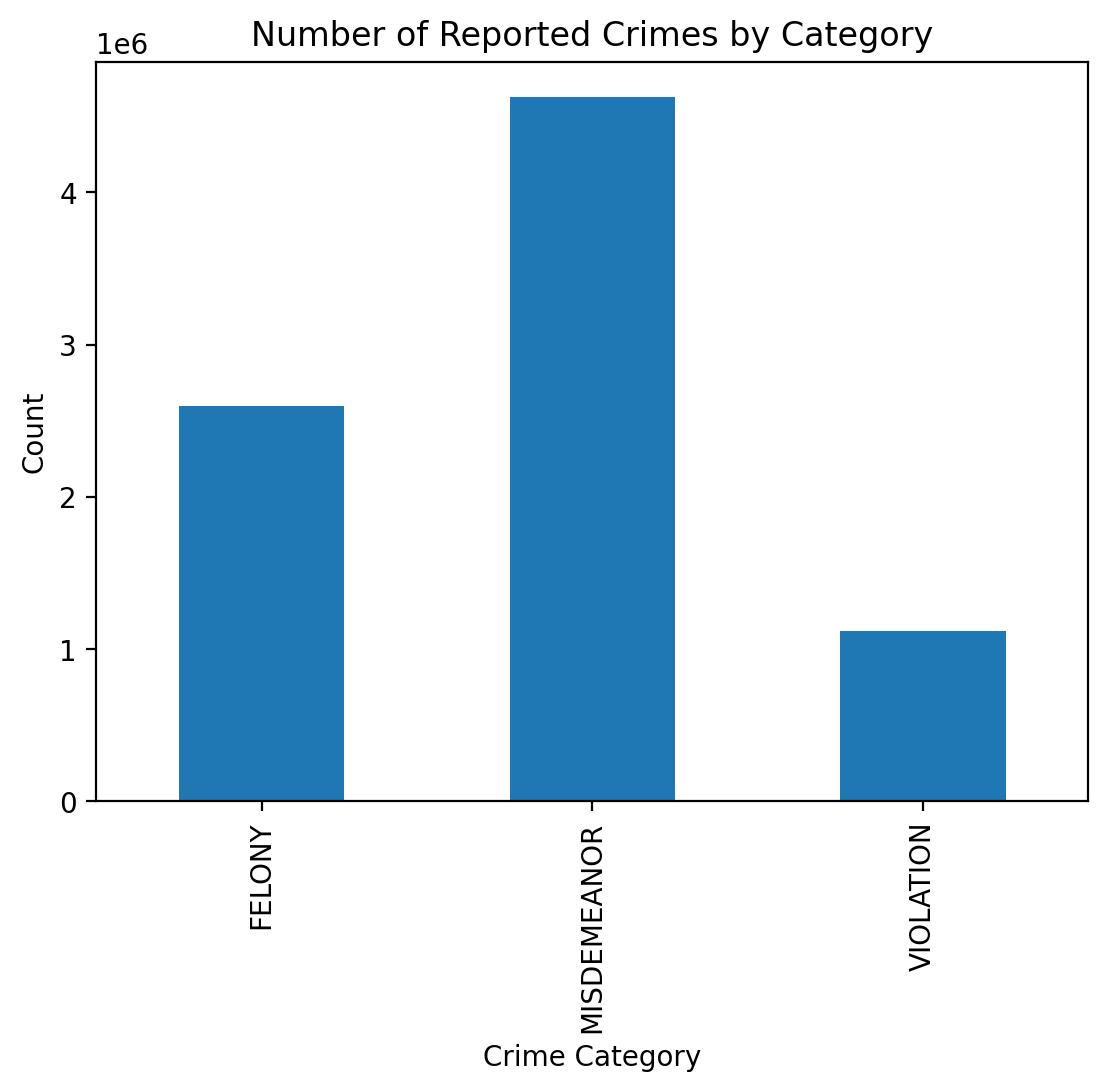

In [7]:
# Create a bar plot showing the values across the three crime types.
df.plot(
x='LAW_CAT_CD', y='count', kind='bar', legend=False
)

# Set plot title and labels
plt.title('Number of Reported Crimes by Category')
plt.xlabel('Crime Category')
plt.ylabel('Count')

# Display the plot
plt.show()

In [8]:
# Question 1c: Across felonies, report the number of crimes, broken down by offense description (as reported in the OFNS_DESC column)

sql = '''
SELECT oc.OFNS_DESC as offense_description, COUNT(*) AS crime_count
FROM nypd
JOIN offense_codes oc ON nypd.KY_CD = oc.KY_CD
WHERE nypd.LAW_CAT_CD = 'FELONY'
GROUP BY oc.OFNS_DESC
ORDER BY crime_count DESC
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,offense_description,crime_count
0,GRAND LARCENY,729798
1,FELONY ASSAULT,334184
2,ROBBERY,297097
3,BURGLARY,282233
4,MISCELLANEOUS PENAL LAW,203660
5,GRAND LARCENY OF MOTOR VEHICLE,157669
6,CRIMINAL MISCHIEF & RELATED OF,151450
7,DANGEROUS DRUGS,92797
8,THEFT-FRAUD,83698
9,FORGERY,82728


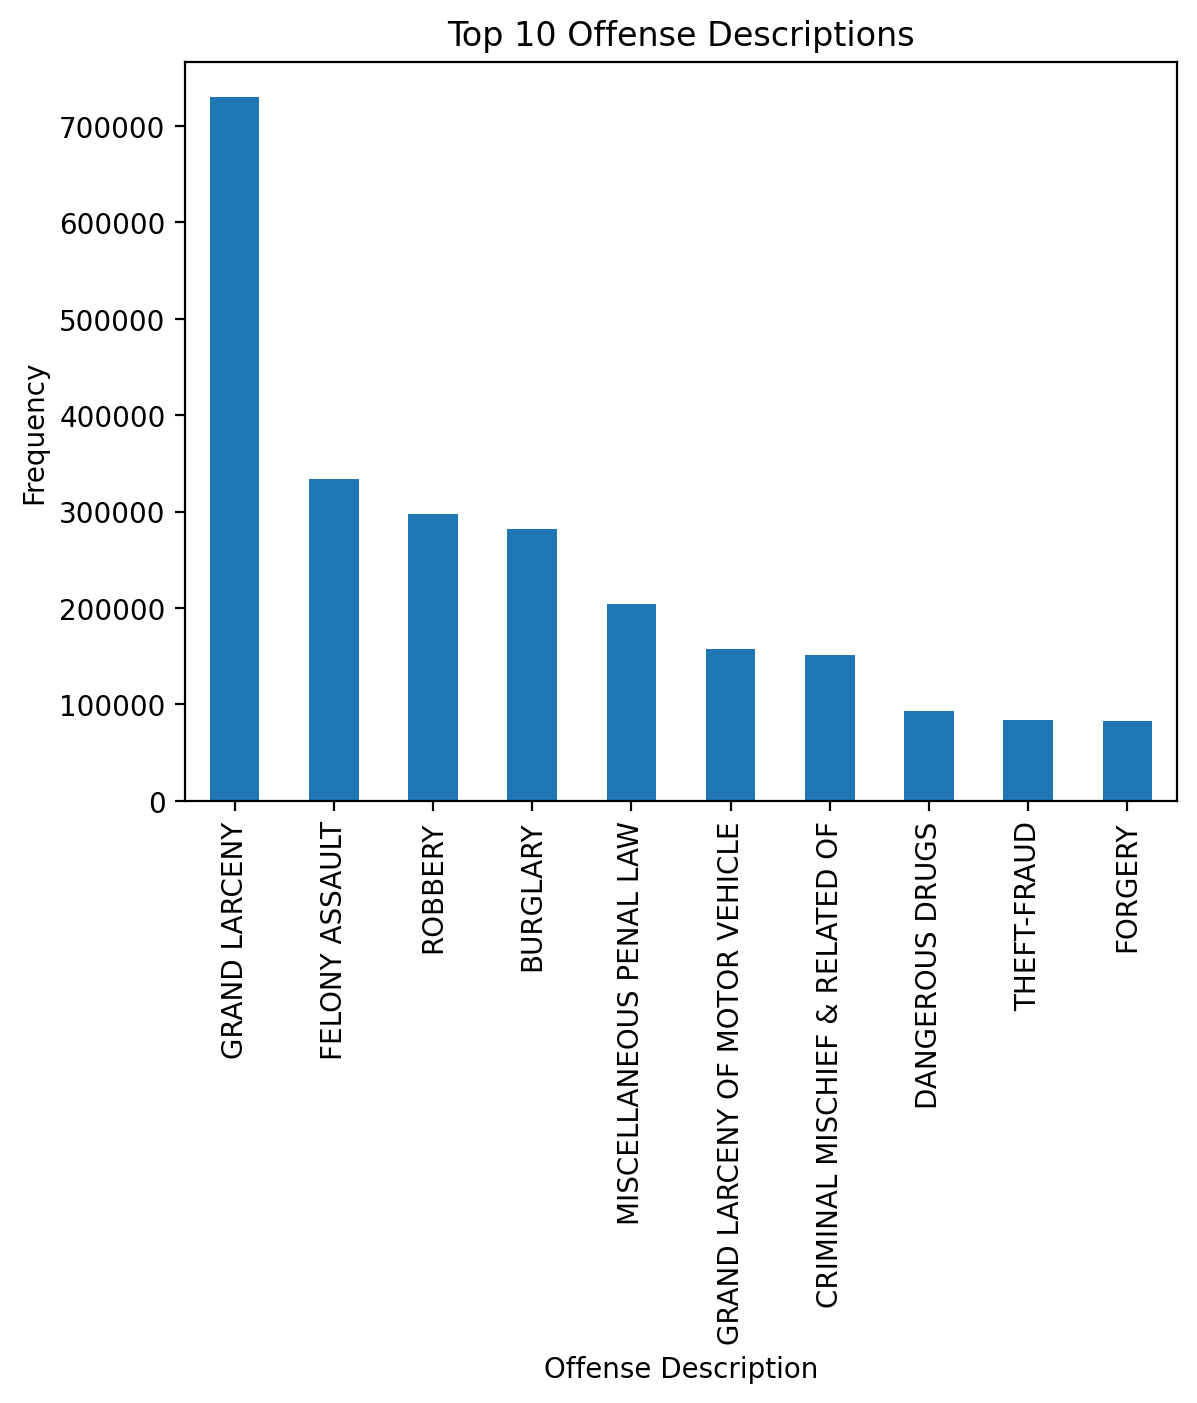

In [9]:
# Create a bar plot showing the frequency of the top-10 offense descriptions

# Sort the DataFrame by count in descending order and select the top 10 rows
top_10_offenses = df.sort_values(by='crime_count', ascending=False).head(10)

# Create a bar plot
top_10_offenses.plot(x='offense_description', y='crime_count', kind='bar', legend=False)

# Set plot title and labels
plt.title('Top 10 Offense Descriptions')
plt.xlabel('Offense Description')
plt.ylabel('Frequency')

# # Display the plot
plt.show()

## Question 2: Is crime increasing or decreasing in NYC?

Use the column `CMPLNT_FR` that reports the date/time of the crime. You are asked to analyze the crimes that happened between January 1st 2006 and December 31st 2022.

* **Question 2a**: Create a plot that shows the *total* number of **all** reported crimes *per year*.

* **Question 2b**: Create a plot that shows the *total* number of **all** reported crimes *per month*  (ie Jan-2006, Feb-2006, ... Jan-2007, Feb-2007, Dec-2022).



**Hint 1**: Be aware that comparisons with dates in MySQL are tricky. You will want to use the format `YYYY-MM-DD` for a date (e.g., "2006-01-01"), so that it gets properly interpreted by MySQL.

**Hint 2**: You can use the `YEAR(CMPLNT_FR)` to extract the year. You can use the `DATE_FORMAT(CMPLNT_FR, '%Y-%m-01')` command in SQL to truncate the field `CMPLNT_FR` and set it to the first day of the month.

**Hint 3**: Alternatively, you can use the  `resample` command in Pandas, to compute statistics on a per-month and per-year basis. If you use resample, remember that you need to make the date column to be the "index" of the dataframe using the `.set_index(CMPLNT_FR)` command (assuming `CMPLNT_FR` is the name of the column with the date) to create a new dataframe with the date being the infex. Be cautious if you get back from SQL the raw datetimes, and  understand the difference between `resample(...).sum()` and `resample(...).mean()`. The `mean()` vs `sum()` can generate very different results, especially when the timestamp variable has a very fine granularity (as happens in our case with `CMPLNT_FR`).

In [10]:
# Question 2a: Create a plot that shows the total number of all reported crimes per year.
sql_year = '''
SELECT YEAR(CMPLNT_FR) AS year, COUNT(*) AS count
FROM nypd
WHERE CMPLNT_FR >= '2006-01-01' AND CMPLNT_FR <= '2022-12-31'
GROUP BY year
'''

with engine.connect() as connection:
	df_year = pd.read_sql(text(sql_year), con=connection)

df_year

,year,count
0,2006,528805
1,2007,535152
2,2008,528603
3,2009,510872
4,2010,510028
5,2011,498557
6,2012,504699
7,2013,495129
8,2014,491186
9,2015,477801


<Figure size 1200x600 with 0 Axes>

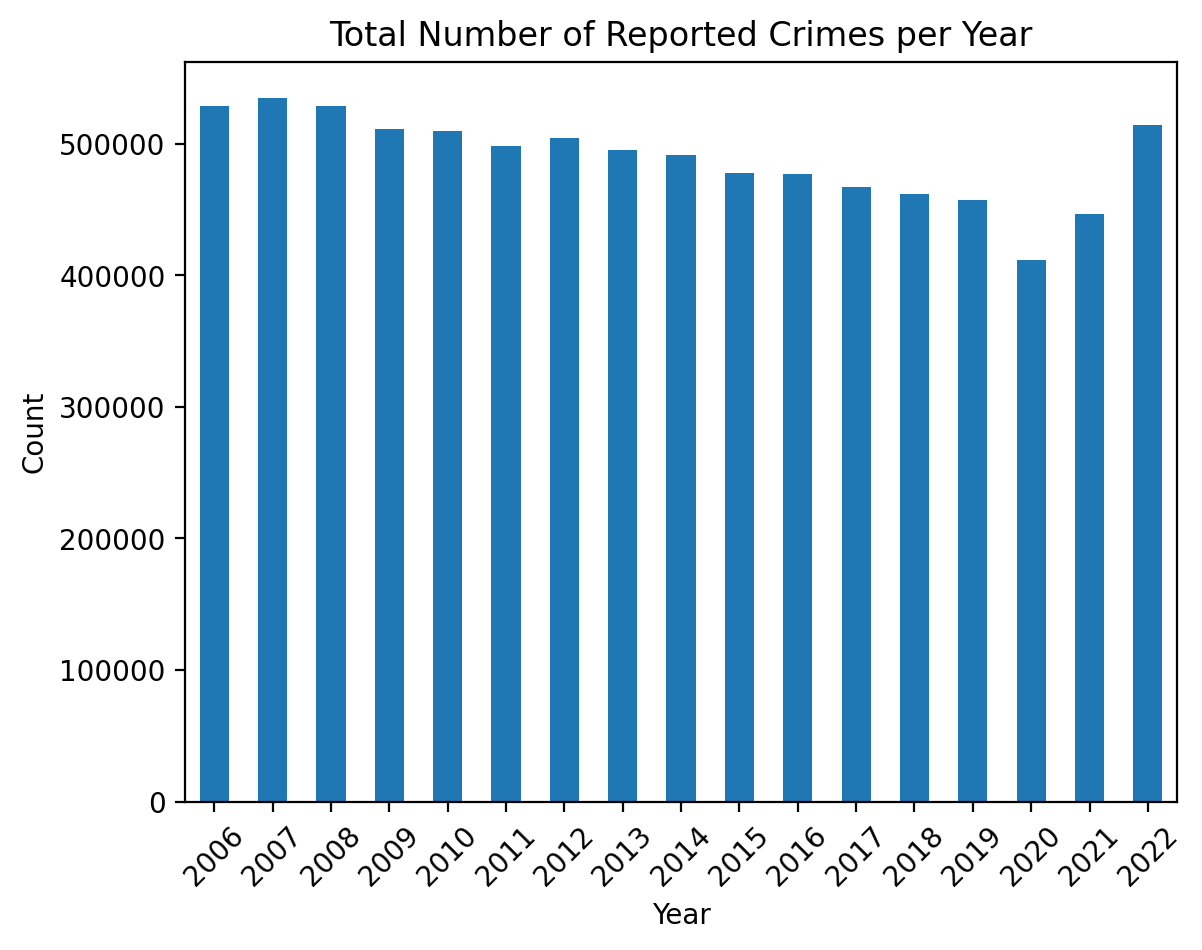

In [11]:
# Create a plot that shows the total number of all reported crimes per year.

plt.figure(figsize=(12, 6))
df_year.plot(x='year', y='count', kind='bar', legend=False)
plt.title('Total Number of Reported Crimes per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

In [12]:
# Question 2b: Create a plot that shows the total number of all reported crimes per month (ie Jan-2006, Feb-2006, ... Jan-2007, Feb-2007, Dec-2022).

sql_month = '''
SELECT DATE_FORMAT(CMPLNT_FR, '%b-%Y') AS month, COUNT(*) AS count
FROM nypd
WHERE CMPLNT_FR >= '2006-01-01' AND CMPLNT_FR <= '2022-12-31'
GROUP BY month
'''

with engine.connect() as connection:
	df_month = pd.read_sql(text(sql_month), con=connection)

df_month



,month,count
0,Jan-2006,43970
1,Feb-2006,36941
2,Mar-2006,43677
3,Apr-2006,42181
4,May-2006,45350
...,...,...
199,Aug-2022,46050
200,Sep-2022,44407
201,Oct-2022,45330
202,Nov-2022,42759


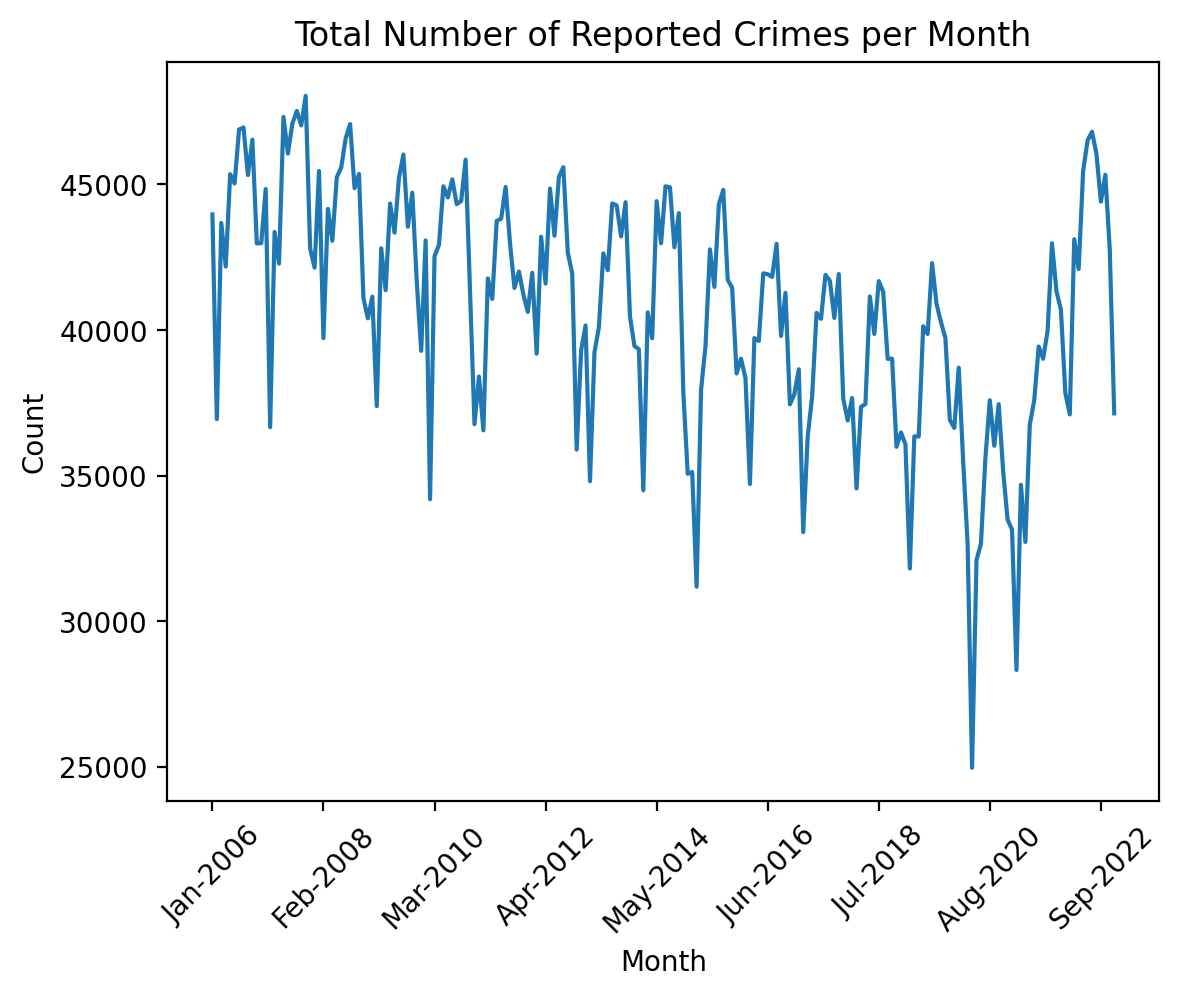

In [14]:
# Question 2b: Create a plot that shows the total number of all reported crimes per month (ie Jan-2006, Feb-2006, ... Jan-2007, Feb-2007, Dec-2022).

df_month.plot(x='month', y='count', kind='line', legend=False)
plt.title('Total Number of Reported Crimes per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

## Question 3: Analysis of the "Big-7" felonies

The NYPD calls the following types of felonies as the "big-7" crimes, as they tend to affect most the quality of life:

* GRAND LARCENY
* ROBBERY
* FELONY ASSAULT
* BURGLARY
* GRAND LARCENY OF MOTOR VEHICLE
* RAPE
* MURDER & NON-NEGL. MANSLAUGHTER


Focus on the big-7 felonies. Report the number of these crimes over time, from 2006 till 2022, **broken down by type of felony**. Focus on reporting the **total** number of crimes per category, on a **per month** basis (Jan-06, Feb-06, ... Dec-22). Generate the associated plot with the number of big-7 felonies over time. You will probably want to make the y-axis logarithmic as the different felonies have different orders of magnitude.

**Hint 1**: The type of felony is included in the `OFNS_DESC` column of the `offense_codes` table and the key for the offense is the `KY_CD` attribute in the main table. You can use the `IN` command in SQL to limit your results to these offenses, or use an `OR` clause. Alternatively, you can use the [`.isin()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isin.html) command in Pandas.

**Hint 2**: If you would like to move the legend outside the plot, you can use the following command: `df.plot(...).legend(bbox_to_anchor=(1, 0.75))`. The two values for the parameter `bbox_to_anchor` describe the x/y location of the legend, compared to the plot. Experiment with different values to understand the effect.


In [15]:
sql = '''
SELECT DATE_FORMAT(nypd.CMPLNT_FR, '%b-%Y') AS month, oc.OFNS_DESC, COUNT(*) AS count
FROM nypd
JOIN offense_codes oc ON nypd.KY_CD = oc.KY_CD
WHERE nypd.CMPLNT_FR >= '2006-01-01' AND nypd.CMPLNT_FR <= '2022-12-31'
    AND oc.OFNS_DESC IN (
        'GRAND LARCENY',
        'ROBBERY',
        'FELONY ASSAULT',
        'BURGLARY',
        'GRAND LARCENY OF MOTOR VEHICLE',
        'RAPE',
        'MURDER & NON-NEGL. MANSLAUGHTER'
    )
GROUP BY month, oc.OFNS_DESC
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,month,OFNS_DESC,count
0,Nov-2021,MURDER & NON-NEGL. MANSLAUGHTER,23
1,Nov-2020,MURDER & NON-NEGL. MANSLAUGHTER,32
2,Apr-2013,MURDER & NON-NEGL. MANSLAUGHTER,23
3,Apr-2015,MURDER & NON-NEGL. MANSLAUGHTER,24
4,May-2016,MURDER & NON-NEGL. MANSLAUGHTER,31
...,...,...,...
1411,Aug-2022,GRAND LARCENY OF MOTOR VEHICLE,1186
1412,Sep-2022,GRAND LARCENY OF MOTOR VEHICLE,1213
1413,Oct-2022,GRAND LARCENY OF MOTOR VEHICLE,1222
1414,Nov-2022,GRAND LARCENY OF MOTOR VEHICLE,1120


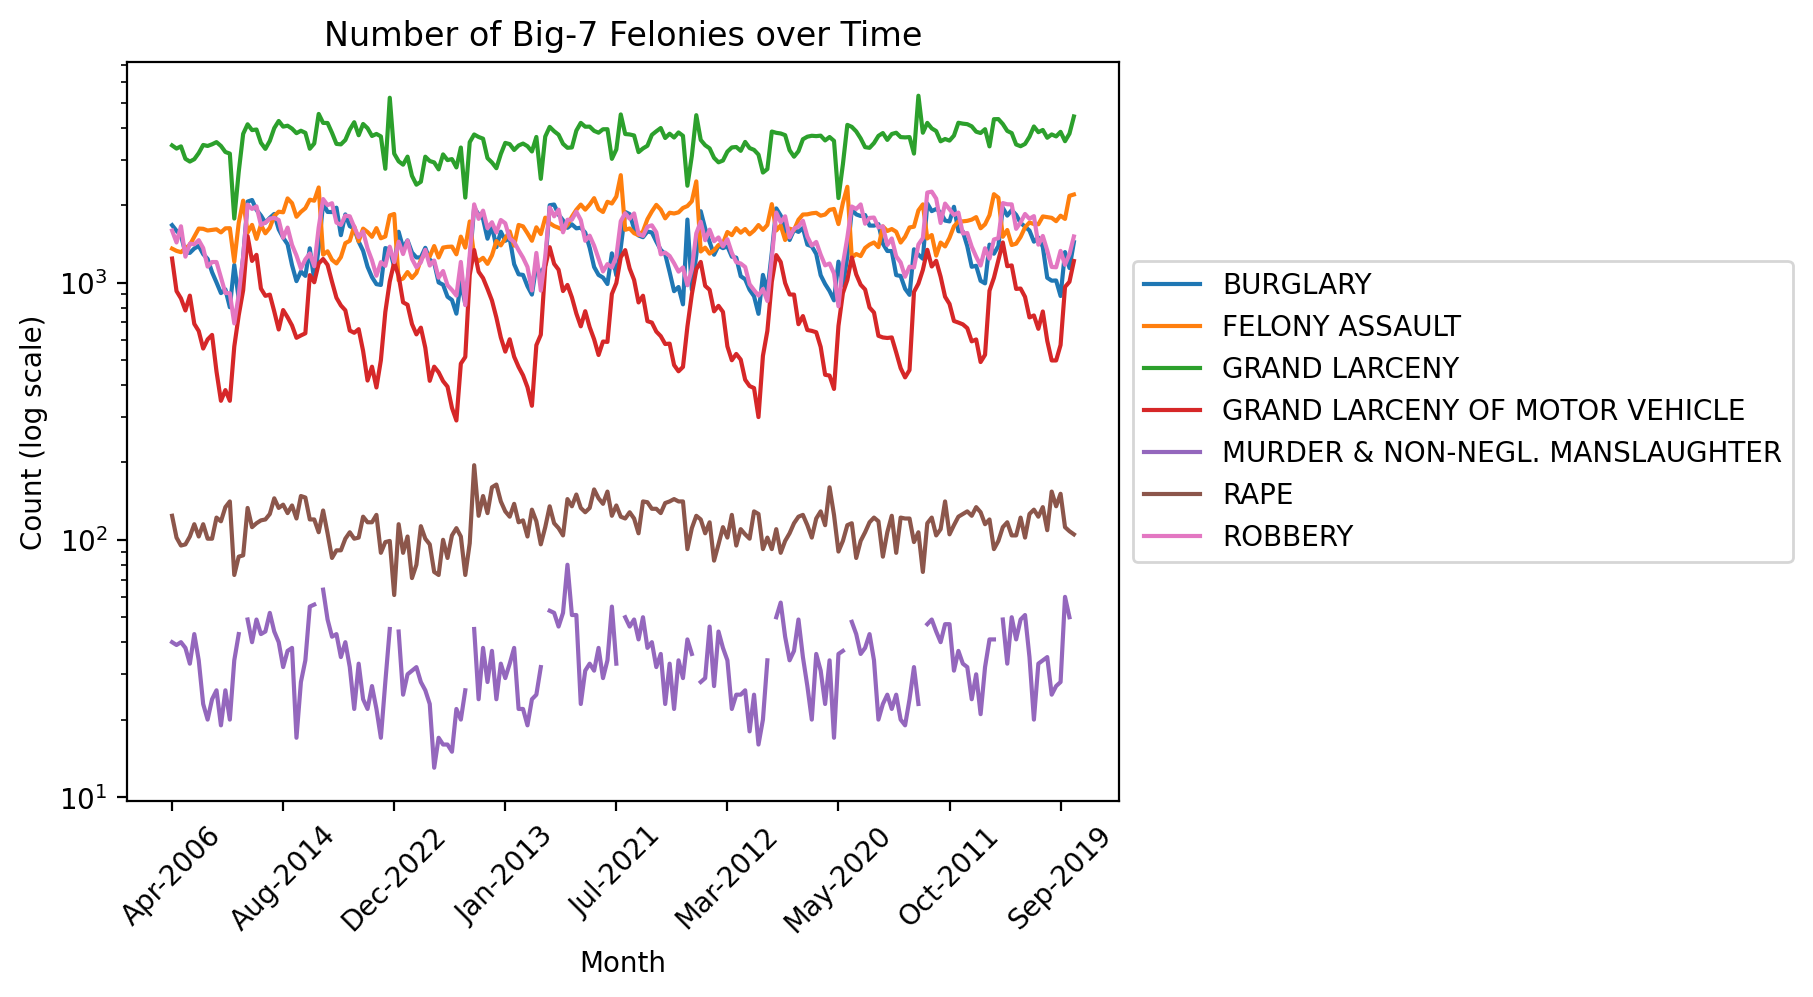

In [16]:
# Pivot the DataFrame to have the felonies as columns and months as rows
df_pivot = df.pivot(index='month', columns='OFNS_DESC', values='count')

# Plotting the number of big-7 felonies over time
df_pivot.plot(logy=True).legend(bbox_to_anchor=(1, 0.75))
plt.title('Number of Big-7 Felonies over Time')
plt.xlabel('Month')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1, 0.75))
plt.grid(False)
plt.show()

## Question 4: Analyze the Big-7 felonies based on hour of the day.

You are now asked to break down the different big-7 felonies by hour of day. We only want to calculate statistics based on the time of the day (i.e., 24 data points per crime). You do *not* need to generate the time series from 2006 to 2022 with hourly granularity.

* **Question 4a**: Show the number of big-7 felonies, broken down by hour of day. (e.g., _8375 reported robberies at 5am_). Generate a plot with the results.

* **Question 4b**: Show the number of big-7 felonies, broken down by hour of day. To allow for easier comparison among felonies, **normalize** the data by dividing by the total incidents for each type of felony.  (e.g., _2.8% of the reported robberies happen at 5am_). Generate a bar plot with the results.


**Hint 1**: You can use the commands `HOUR()`  in SQL, to extract the hour.

**Hint 2**: When creating plots, you may prefer to put the plot for each columns of the dataframe in a separate plot. The option `subplots=True` for the `df.plot()` command provides that capability. (See [the related documentation](https://pandas.pydata.org/pandas-docs/stable/visualization.html#subplots).) If you use the `subplots=True`, you can also use the `layout=(num_rows, num_columns)` option to specify the number of rows (`num_rows`) and the number of columns (`num_columns`) to use for the grid arrangement.


In [17]:
sql = '''
SELECT HOUR(nypd.CMPLNT_FR) AS hour, oc.OFNS_DESC, COUNT(*) AS count
FROM nypd
JOIN offense_codes oc ON nypd.KY_CD = oc.KY_CD
WHERE nypd.KY_CD IN (
    SELECT KY_CD
    FROM offense_codes
    WHERE OFNS_DESC IN (
        'GRAND LARCENY',
        'ROBBERY',
        'FELONY ASSAULT',
        'BURGLARY',
        'GRAND LARCENY OF MOTOR VEHICLE',
        'RAPE',
        'MURDER & NON-NEGL. MANSLAUGHTER'
    )
)
GROUP BY hour, oc.OFNS_DESC
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,hour,OFNS_DESC,count
0,1,MURDER & NON-NEGL. MANSLAUGHTER,394
1,11,MURDER & NON-NEGL. MANSLAUGHTER,147
2,12,MURDER & NON-NEGL. MANSLAUGHTER,225
3,20,MURDER & NON-NEGL. MANSLAUGHTER,358
4,22,MURDER & NON-NEGL. MANSLAUGHTER,464
...,...,...,...
163,3,GRAND LARCENY OF MOTOR VEHICLE,3523
164,11,GRAND LARCENY OF MOTOR VEHICLE,4336
165,8,GRAND LARCENY OF MOTOR VEHICLE,4843
166,6,GRAND LARCENY OF MOTOR VEHICLE,3193


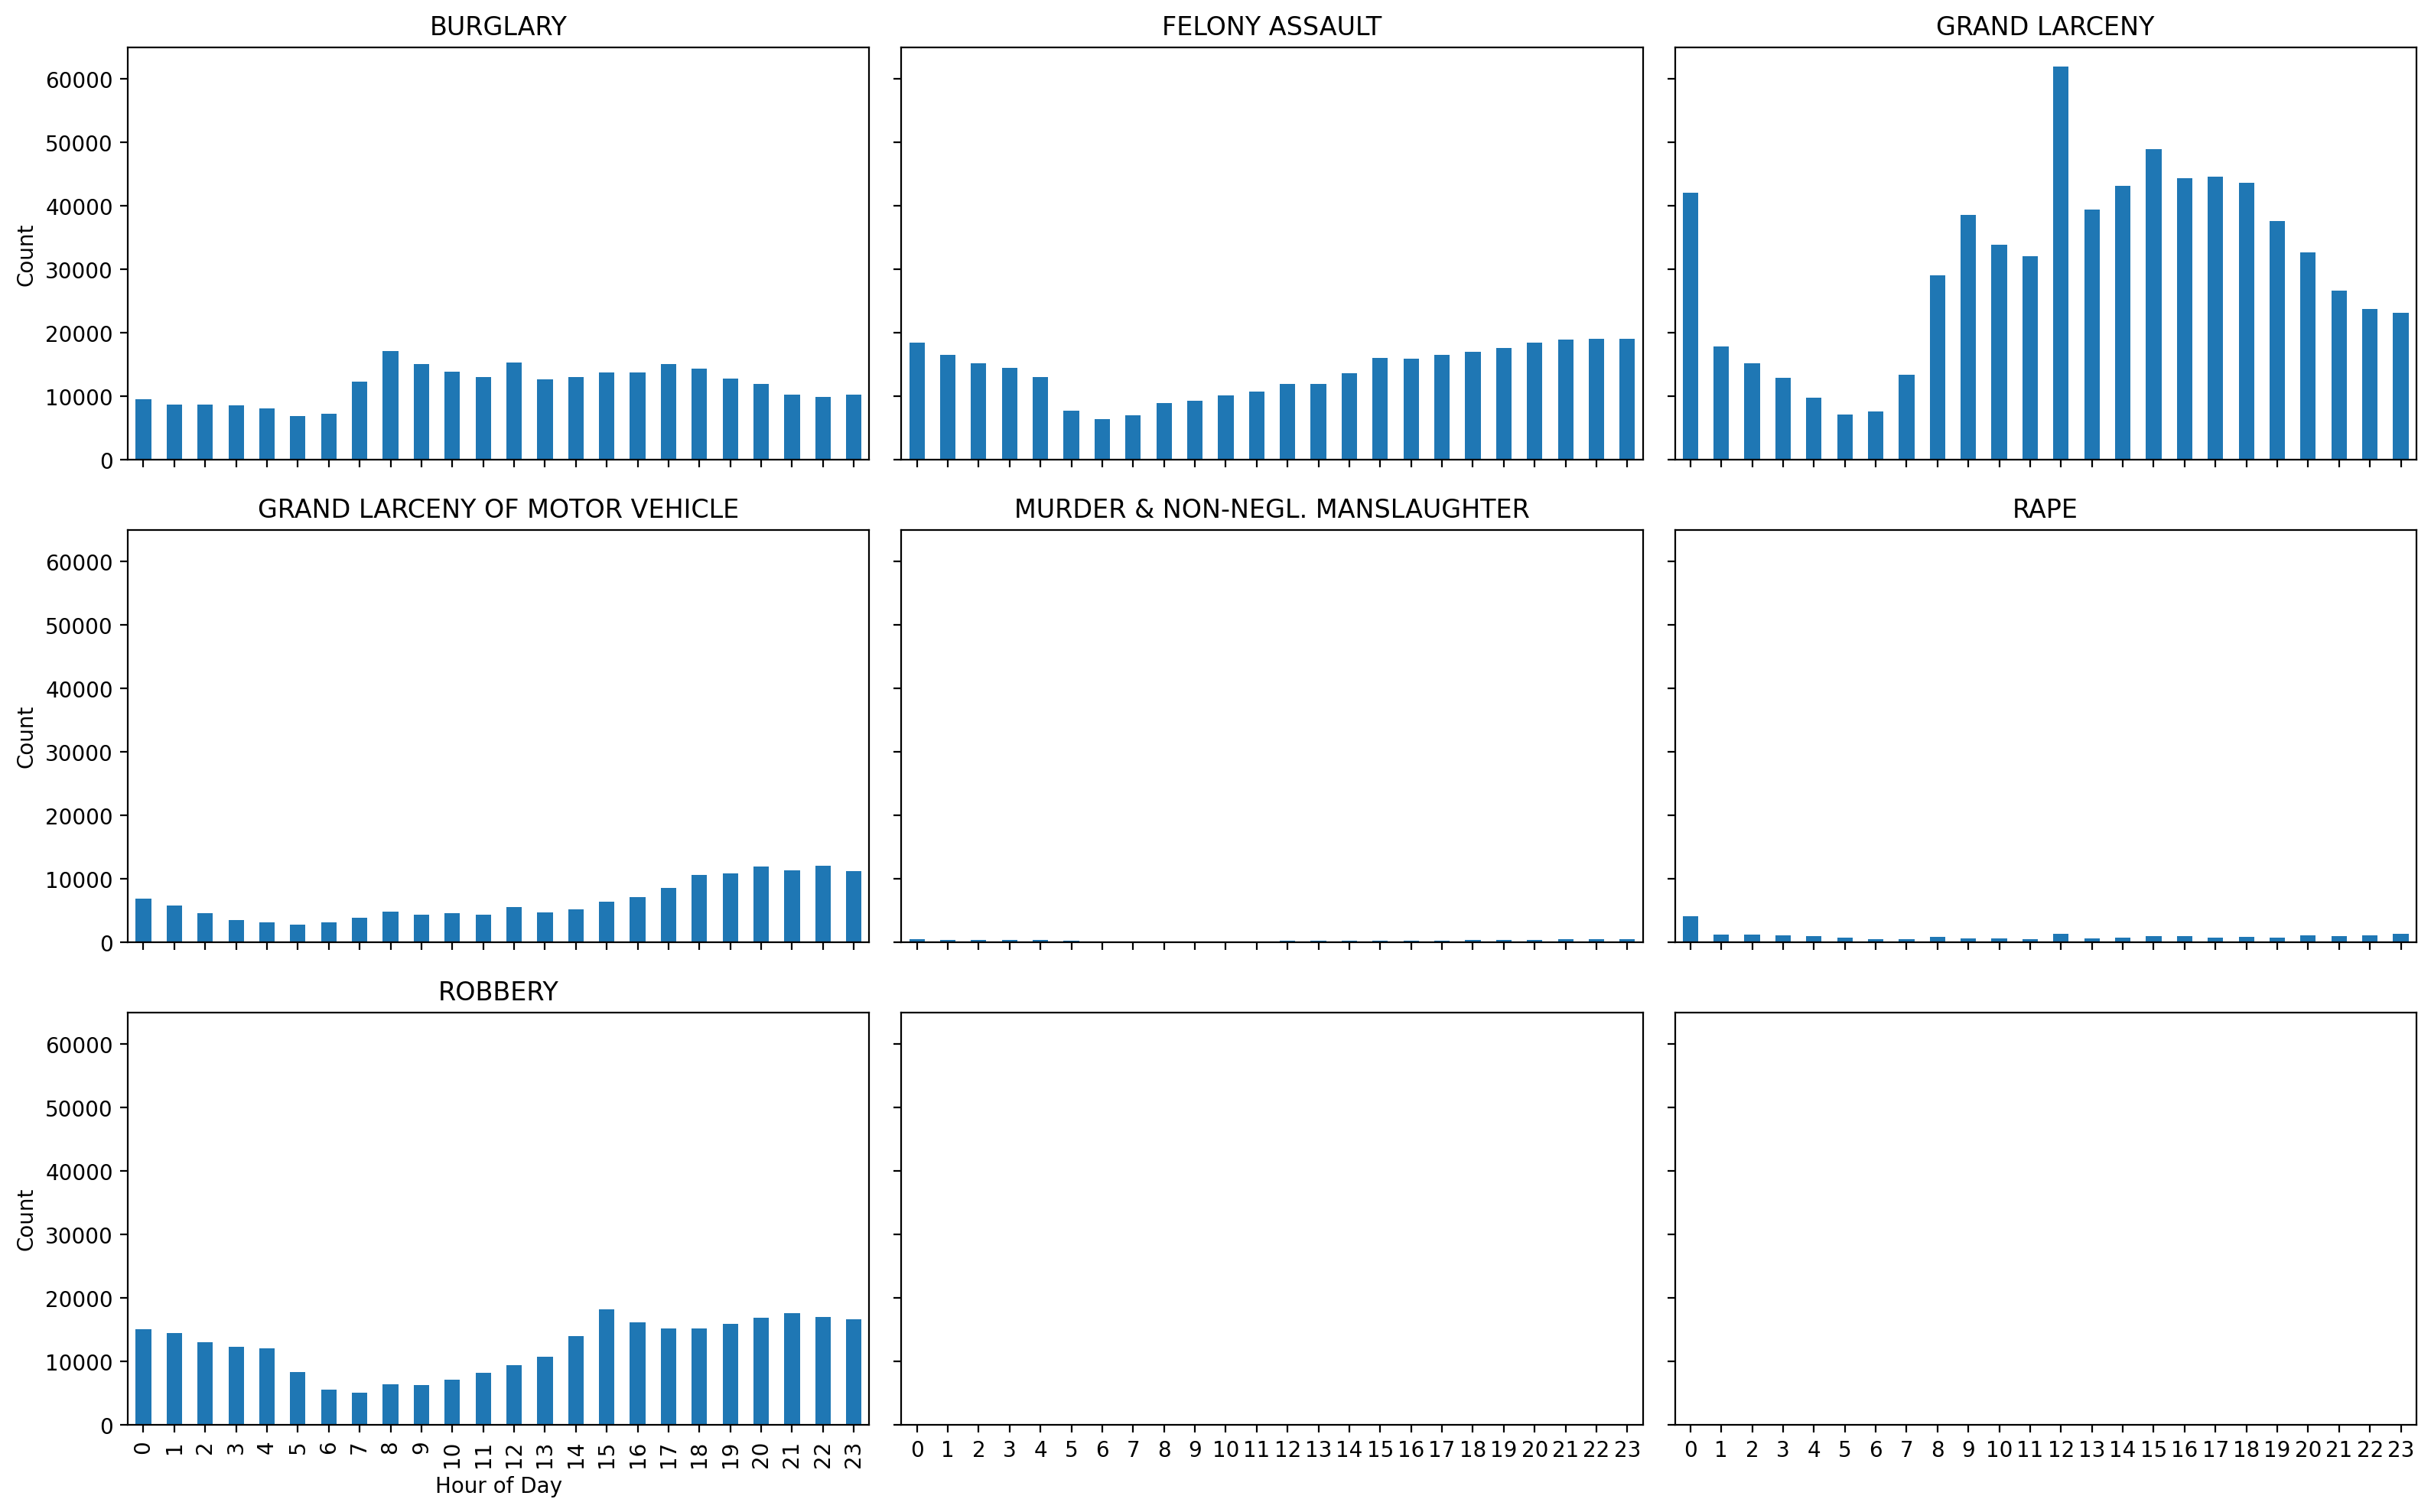

In [18]:
# Question 4a: Show the number of big-7 felonies, broken down by hour of day.
 # (e.g., 8375 reported robberies at 5am). Generate a plot with the results.

# Pivot the DataFrame to have the felonies as columns and hours as rows
df_pivot = df.pivot(index='hour', columns='OFNS_DESC', values='count')

# Plotting the number of big-7 felonies, broken down by hour of day
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 10), sharey=True, sharex=True)

for i, (col, ax) in enumerate(zip(df_pivot.columns, axes.flatten())):
    df_pivot[col].plot(ax=ax, kind='bar', legend=False)
    ax.set_title(col)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Count')
    ax.grid(False)

plt.tight_layout()
plt.show()

In [19]:
# Question 4b: Show the number of big-7 felonies, broken down by hour of day.
# To allow for easier comparison among felonies, normalize the data by dividing
# by the total incidents for each type of felony. (e.g., 2.8% of the reported
# robberies happen at 5am). Generate a bar plot with the results.

sql = '''
SELECT HOUR(n.CMPLNT_FR) AS hour, oc.OFNS_DESC, COUNT(*) AS count
FROM nypd n
JOIN offense_codes oc ON n.KY_CD = oc.KY_CD
WHERE oc.OFNS_DESC IN (
    'GRAND LARCENY',
    'ROBBERY',
    'FELONY ASSAULT',
    'BURGLARY',
    'RAPE',
    'MURDER',
    'GRAND LARCENY OF MOTOR VEHICLE'
) AND n.Latitude IS NOT NULL AND n.Longitude IS NOT NULL
GROUP BY hour, oc.OFNS_DESC
'''

with engine.connect() as connection:
    # Execute the SQL query and retrieve the results as a DataFrame
    df = pd.read_sql(text(sql), con=connection)

df

,hour,OFNS_DESC,count
0,23,GRAND LARCENY OF MOTOR VEHICLE,11099
1,21,ROBBERY,17534
2,9,GRAND LARCENY,38420
3,12,GRAND LARCENY OF MOTOR VEHICLE,5557
4,12,GRAND LARCENY,61655
...,...,...,...
139,11,RAPE,523
140,10,RAPE,581
141,12,RAPE,1389
142,7,RAPE,486


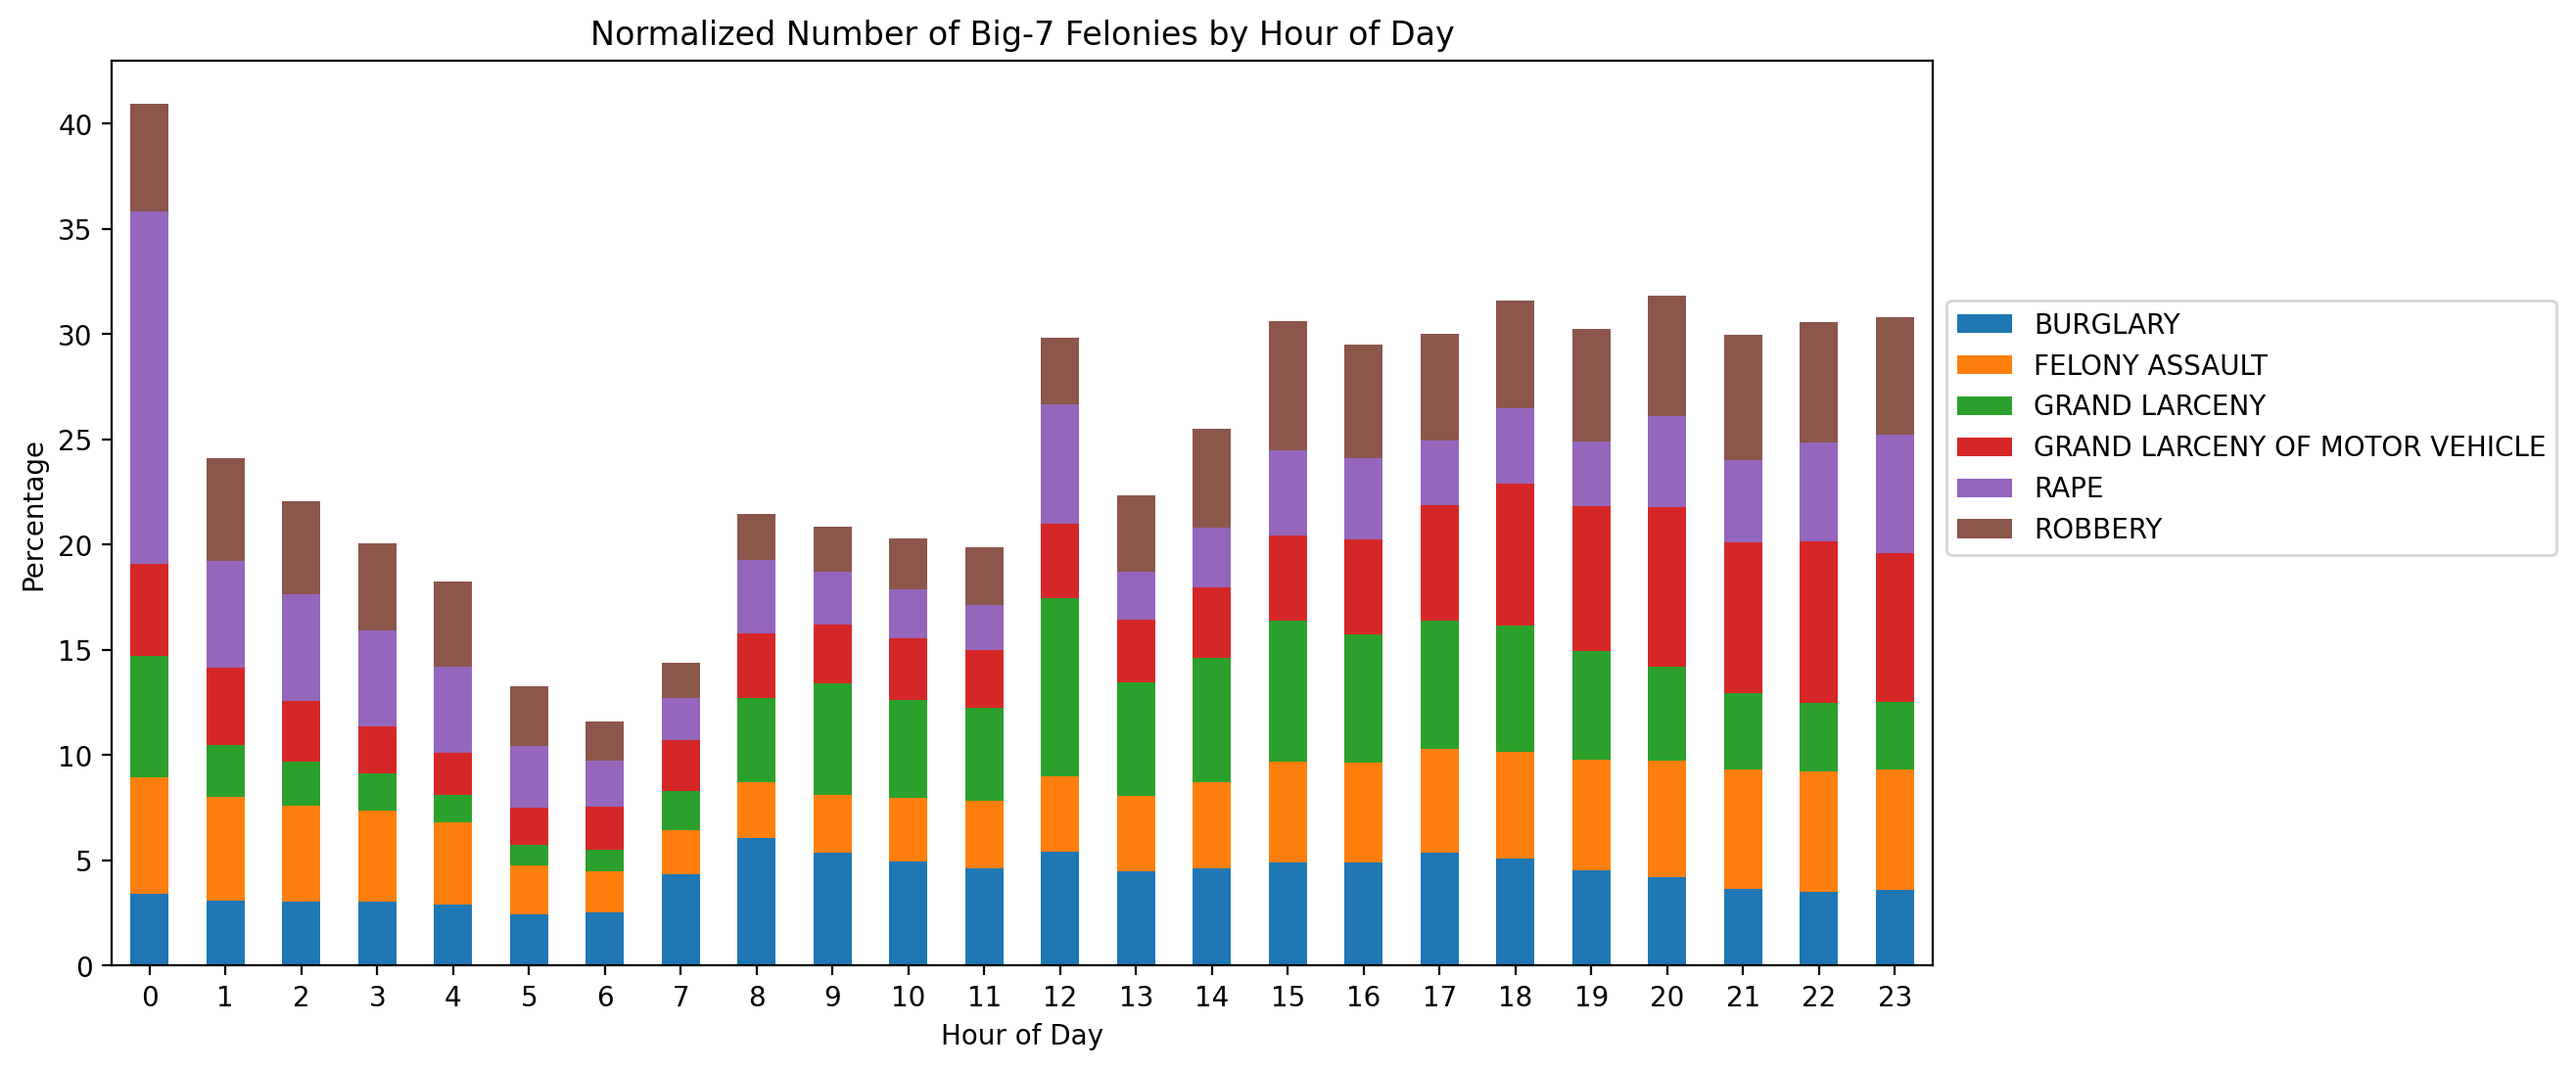

In [20]:
# Pivot the DataFrame to have the felonies as columns and hours as rows
df_pivot = df.pivot(index='hour', columns='OFNS_DESC', values='count')

# Calculate the total incidents for each type of felony
total_incidents = df_pivot.sum(axis=0)

# Normalize the data by dividing by the total incidents for each type of felony
df_normalized = df_pivot.div(total_incidents) * 100

# Plotting the normalized number of big-7 felonies broken down by hour of day
df_normalized.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Normalized Number of Big-7 Felonies by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1, 0.75))
plt.grid(False)
plt.show()

## Question 5: Spatial Analysis

You are asked to analyze the spatial density for the following types of felonies:

* GRAND LARCENY
* ROBBERY
* FELONY ASSAULT
* BURGLARY
* GRAND LARCENY OF MOTOR VEHICLE

Use the `Latitude` and `Longitude` variables from the dataset to identify the location of each crime. (FYI, for victim privacy, the reported rapes and murders do not have geocoding variables associated with them.) **Limit your analysis to  dates in 2022 and to crimes where  `Latitude` and `Longitude` are not NULL .**

**Hint 1**: Remember that if you do a 2d density estimation, you can speed up the computation by taking just a sample of the data that you analyze using the `dataframe.sample()` command.

**Hint 2**: If you could like to plot a map of NYC under your density plot, you can use the shapefile of NYC neighborhoods from NYC Open Data. See the code below.

**Hint 3**: You will need to generate 5 different heatmaps, one for each of the five types of felonies listed above.

In [21]:
# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
!curl 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON' -o nyc-neighborhoods.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4370k    0 4370k    0     0  3666k      0 --:--:--  0:00:01 --:--:-- 3666k


<Axes: >

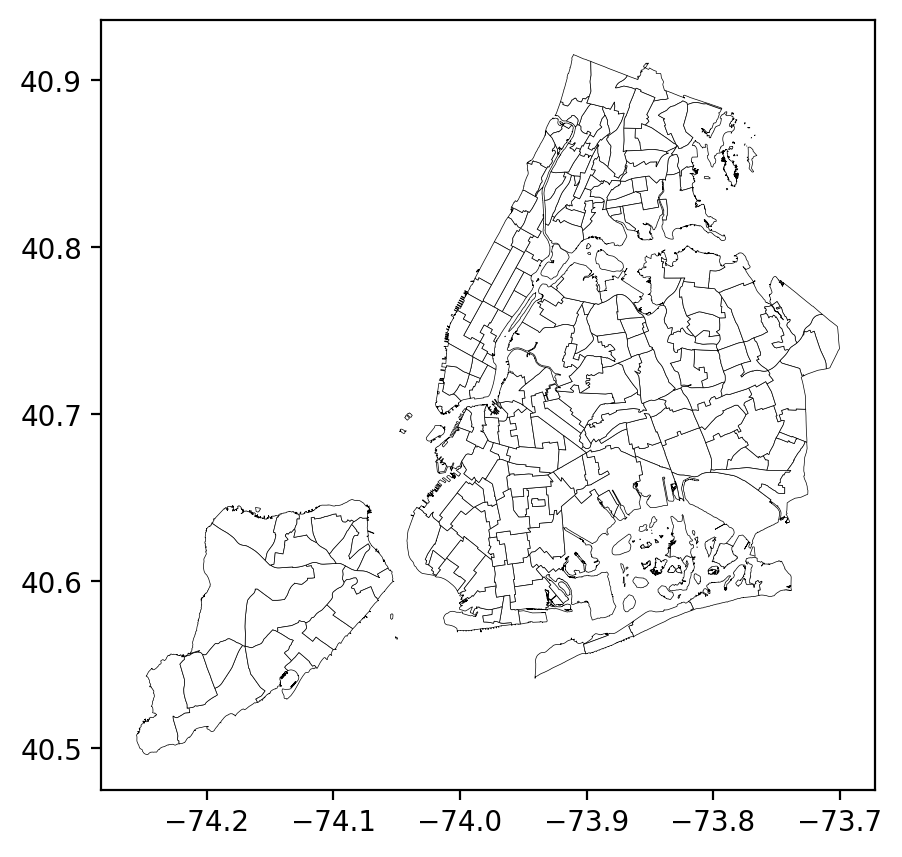

In [22]:
# Load the shapefile
df_nyc = gpd.GeoDataFrame.from_file('nyc-neighborhoods.geojson')

# Create a plot
df_nyc.plot(linewidth=0.25, color='White', edgecolor='Black', figsize=(5, 5))

In [23]:
sql = '''
SELECT
X.Latitude,
X.Longitude,
Y.OFNS_DESC as Offense
FROM nypd X
LEFT JOIN offense_codes Y on X.KY_CD=Y.KY_CD
WHERE Y.OFNS_DESC IN ('GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE')
AND X.Latitude IS NOT NULL AND X.Longitude IS NOT NULL AND X.CMPLNT_FR BETWEEN '2022-01-01' AND '2022-12-31'
'''


with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,Latitude,Longitude,Offense
0,40.697994,-73.797859,FELONY ASSAULT
1,40.741043,-74.007729,GRAND LARCENY
2,40.753555,-73.985046,GRAND LARCENY
3,40.872524,-73.912483,FELONY ASSAULT
4,40.761974,-73.986336,GRAND LARCENY
...,...,...,...
119664,40.686020,-73.870308,FELONY ASSAULT
119665,40.834068,-73.875206,ROBBERY
119666,40.766930,-73.986435,GRAND LARCENY
119667,40.807774,-73.852631,GRAND LARCENY OF MOTOR VEHICLE


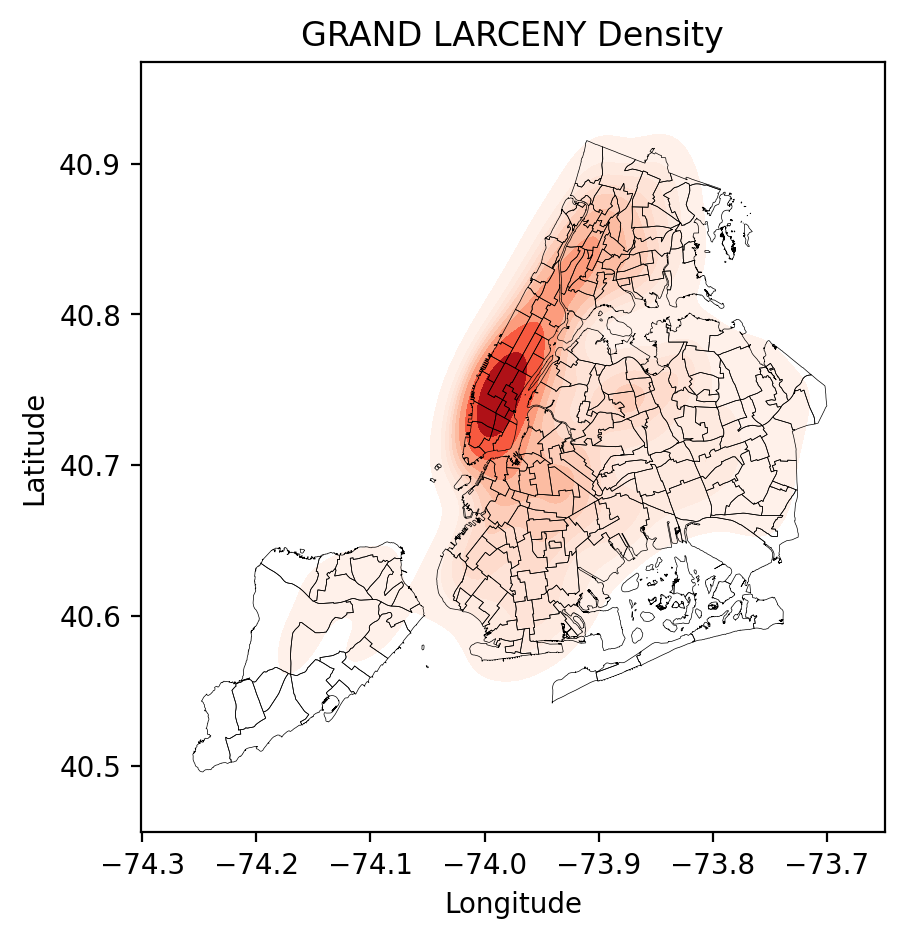

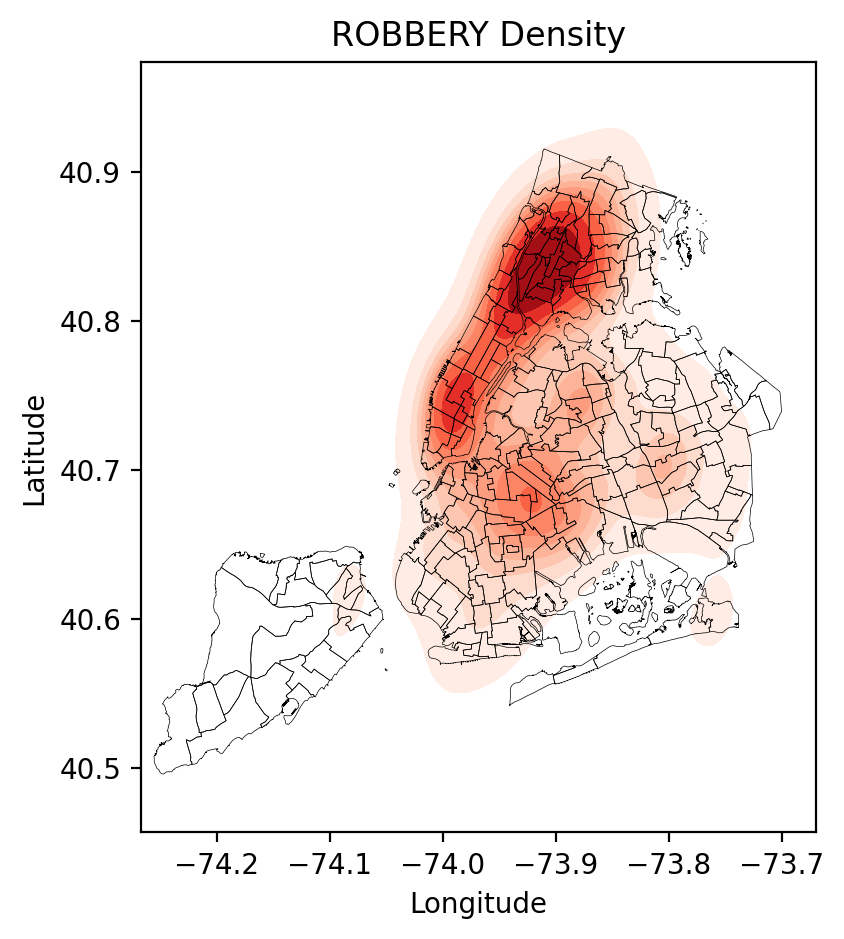

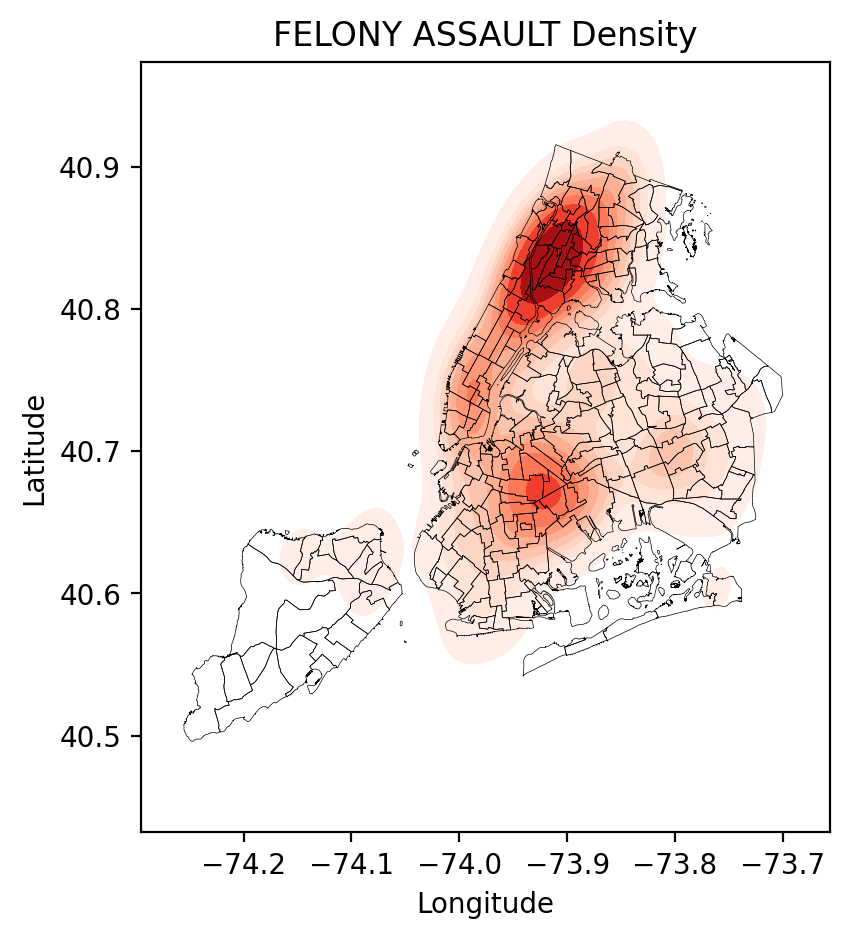

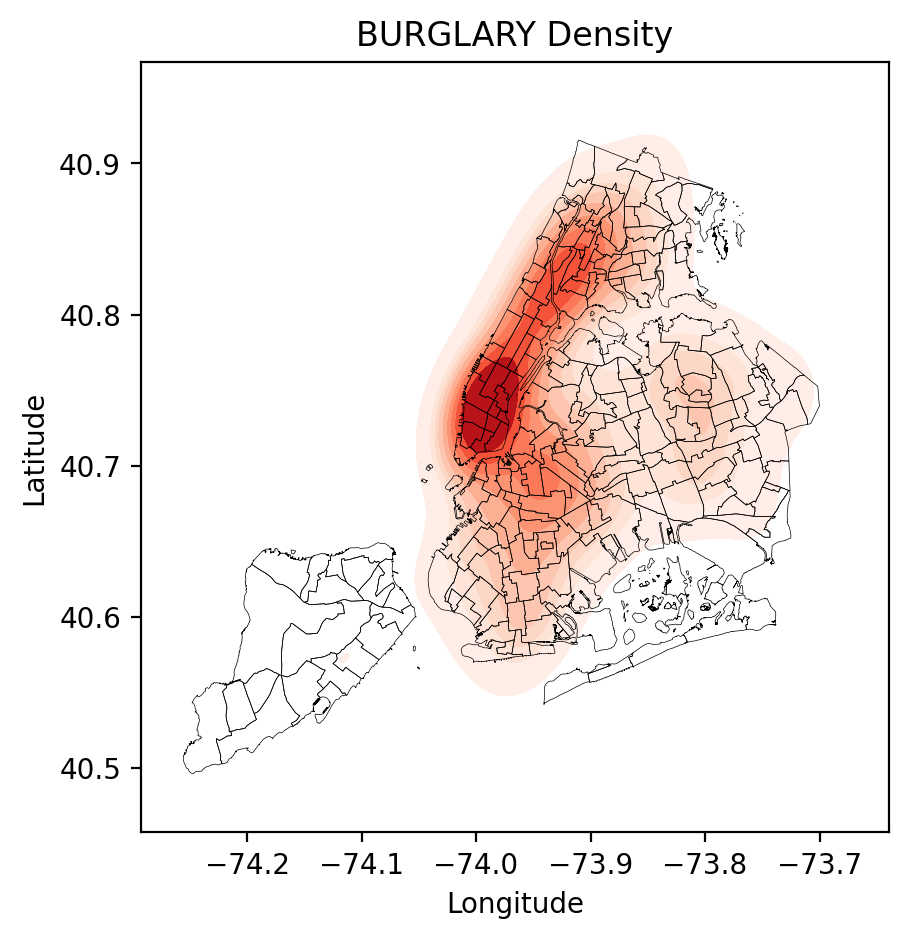

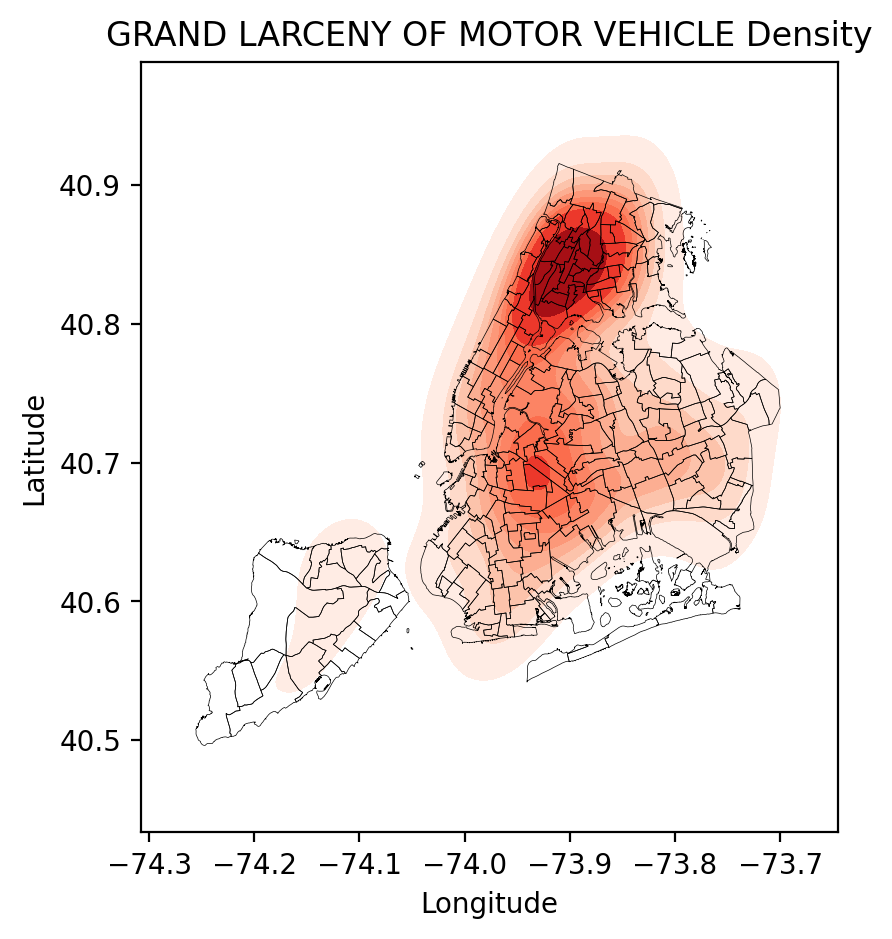

In [24]:
felonies = ['GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE']
for felony in felonies:
    df_felony = df[df['Offense'] == felony]
    fig, ax = plt.subplots(figsize=(5, 5))
    df_sample = df_felony.sample(frac=0.1)
    sns.kdeplot(data=df_sample, x='Longitude', y='Latitude', fill=True, cmap='Reds', ax=ax)
    df_nyc.plot(linewidth=0.25, color='None', edgecolor='Black', ax=ax)

    plt.title(f'{felony} Density')
    plt.show()